In [0]:
import pandas as pd
import numpy as np
# read data
reviews_df_main = pd.read_excel("RC.xlsx")
reviews_df = pd.DataFrame()
reviews_df['review'] = reviews_df_main["Review"]
reviews_df['OTA'] = reviews_df_main['OTA']
reviews_df.head()

,review,OTA
0,"Hello all, I am writing a review on Makemytrip...",MMT
1,"Hello Friends,\nI have booked a room in Raddis...",MMT
2,I was trying to book an intl flight for 4 pass...,MMT
3,Unbeatable match with other trip booking apps ...,MMT
4,They cannot be reliable in matter of hotel boo...,MMT


In [0]:
reviews_df["review"] = [x.replace("\n", " ") for x in reviews_df["review"] ]

In [0]:

# return the wordnet object value corresponding to the POS tag
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import wordnet

def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
import string
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer

def clean_text(text):
    # lower text
    text = text.lower()
    # tokenize text and remove puncutation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # remove stop words
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    # remove empty tokens
    text = [t for t in text if len(t) > 0]
    # pos tag text
    pos_tags = pos_tag(text)
    # lemmatize text
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    # remove words with only one letter
    text = [t for t in text if len(t) > 1]
    # join all
    text = " ".join(text)
    return(text)

# clean text data
reviews_df["review"] = reviews_df["review"].apply(lambda x : str(x))
reviews_df["review_clean"] = reviews_df['review'].apply(lambda x: clean_text(x))
reviews_df.head()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


,review,OTA,review_clean
0,"Hello all, I am writing a review on Makemytrip...",MMT,hello write review makemytrip.com reference ex...
1,"Hello Friends, I have booked a room in Raddiso...",MMT,hello friend book room raddison atrium banglor...
2,I was trying to book an intl flight for 4 pass...,MMT,try book intl flight passenger chennai bangkok...
3,Unbeatable match with other trip booking apps ...,MMT,unbeatable match trip book apps trust worthy a...
4,They cannot be reliable in matter of hotel boo...,MMT,cannot reliable matter hotel booking happen ha...


In [0]:
# add sentiment anaylsis columns
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()
reviews_df["sentiments"] = reviews_df["review"].apply(lambda x: sid.polarity_scores(x))
reviews_df = pd.concat([reviews_df.drop(['sentiments'], axis=1), reviews_df['sentiments'].apply(pd.Series)], axis=1)
reviews_df

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


,review,OTA,review_clean,neg,neu,pos,compound
0,"Hello all, I am writing a review on Makemytrip...",MMT,hello write review makemytrip.com reference ex...,0.000,0.785,0.215,0.9970
1,"Hello Friends, I have booked a room in Raddiso...",MMT,hello friend book room raddison atrium banglor...,0.097,0.860,0.043,-0.4435
2,I was trying to book an intl flight for 4 pass...,MMT,try book intl flight passenger chennai bangkok...,0.019,0.807,0.173,0.9412
3,Unbeatable match with other trip booking apps ...,MMT,unbeatable match trip book apps trust worthy a...,0.000,0.729,0.271,0.9837
4,They cannot be reliable in matter of hotel boo...,MMT,cannot reliable matter hotel booking happen ha...,0.000,0.954,0.046,0.4310
...,...,...,...,...,...,...,...
2242,"Guys, I have booked tickets from redbus in ord...",Redbus,guy book ticket redbus order save time around ...,0.077,0.863,0.060,-0.0757
2243,"had booked from Delhi to shimla Volvo AC, but...",Redbus,book delhi shimla volvo ac go board point one ...,0.088,0.811,0.101,0.3530
2244,"Hey guys, dont book tickets from Redbus. Horri...",Redbus,hey guy dont book ticket redbus horrible exper...,0.100,0.858,0.042,-0.6597
2245,"Red bus, it's a part of scam. Please dont book...",Redbus,red bus part scam please dont book ticket redb...,0.057,0.858,0.084,0.6622


In [0]:
# add number of characters column
reviews_df["nb_chars"] = reviews_df["review"].apply(lambda x: len(x))

# add number of words column
reviews_df["nb_words"] = reviews_df["review"].apply(lambda x: len(x.split(" ")))

In [0]:
# create doc2vec vector columns
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(reviews_df["review_clean"].apply(lambda x: x.split(" ")))]

# train a Doc2Vec model with our text data
model = Doc2Vec(documents, vector_size=5, window=2, min_count=1, workers=4)

# transform each document into a vector data
doc2vec_df = reviews_df["review_clean"].apply(lambda x: model.infer_vector(x.split(" "))).apply(pd.Series)
doc2vec_df.columns = ["doc2vec_vector_" + str(x) for x in doc2vec_df.columns]
reviews_df = pd.concat([reviews_df, doc2vec_df], axis=1)

In [0]:
# add tf-idfs columns
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(min_df = 10)
tfidf_result = tfidf.fit_transform(reviews_df["review_clean"]).toarray()
tfidf_df = pd.DataFrame(tfidf_result, columns = tfidf.get_feature_names())
tfidf_df.columns = ["word_" + str(x) for x in tfidf_df.columns]
tfidf_df.index = reviews_df.index
reviews_df = pd.concat([reviews_df, tfidf_df], axis=1)

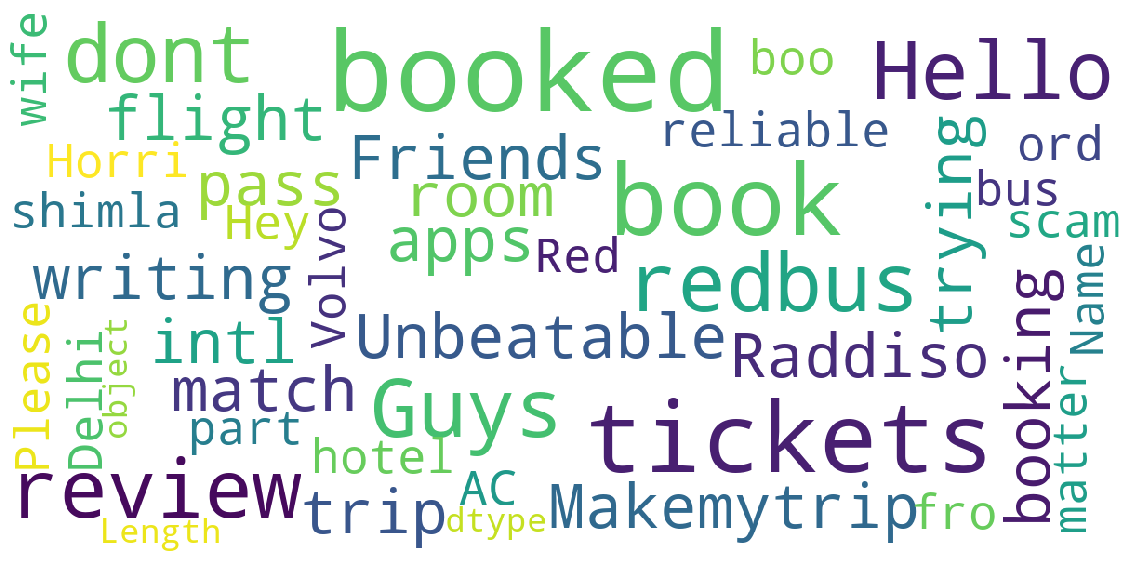

In [0]:
# wordcloud function
%matplotlib inline
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 200,
        max_font_size = 40, 
        scale = 3,
        random_state = 42
    ).generate(str(data))

    fig = plt.figure(1, figsize = (20, 20))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()
    
# print wordcloud
show_wordcloud(reviews_df["review"])

In [0]:
total_positive = len(reviews_df[reviews_df["compound"] >= 0 ])
total_negative = len(reviews_df[reviews_df["compound"] < 0 ])
print("negative reviews:", total_negative )
print("positive reviews:", total_positive )
total = total_negative + total_positive
print("total: ", total )
#reviews_df[reviews_df["compound"] < 0 ].sort_values("compound", ascending=True)[["review","OTA", "neg","pos", "compound"]].head()

negative reviews: 1113
positive reviews: 1134
total:  2247


In [0]:
# highest positive sentiment reviews (with more than 5 words)
reviews_df[reviews_df["nb_words"] >= 5].sort_values("compound", ascending = False)[["review","OTA", "pos","neg", "compound"]].head(10)


,review,OTA,pos,neg,compound
1603,During our Himachal Tour in March 2016 I was i...,Goibibo,0.176,0.013,0.9992
1763,"Hello Friends, I am Vikas Kumar Raghav. Now I ...",Goibibo,0.302,0.000,0.9991
1873,We go for any trips with transport but through...,Redbus,0.329,0.000,0.9973
0,"Hello all, I am writing a review on Makemytrip...",MMT,0.215,0.000,0.9970
1200,During our Himachal Tour in March 2016 I was i...,Goibibo,0.162,0.012,0.9969
1272,During our Himachal Tour in March 2016 I was i...,Goibibo,0.162,0.012,0.9969
1309,In the month of April 2017 I was planning a tr...,Goibibo,0.208,0.025,0.9962
297,Stayed at The Pleasant Haveli Jaisalmer from 2...,MMT,0.229,0.020,0.9962
1683,In the month of April 2017 I was planning a tr...,Goibibo,0.207,0.025,0.9962
1239,In the month of April 2017 I was planning a tr...,Goibibo,0.208,0.025,0.9962


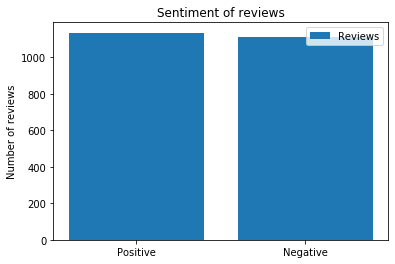

In [0]:
sentiment=['Positive','Negative']
revenue=[total_positive, total_negative]
xpos = np.arange(len(sentiment))
plt.bar(xpos,revenue, label="Reviews")

plt.xticks(xpos,sentiment)
plt.ylabel("Number of reviews")
plt.title('Sentiment of reviews')
plt.legend()

In [0]:

#reviews_df[reviews_df['OTA'] == 'MMT'].sort_values("compound", ascending = True)[["review","OTA",  "neg","pos", "compound"]].head(10)
'''
mmt_pos = len(reviews_df[(reviews_df['OTA'] == 'MMT') & (reviews_df["compound"] > 0 ) ])
mmt_neg = len(reviews_df[(reviews_df['OTA'] == 'MMT') & (reviews_df["compound"] < 0 ) ])
yatra_pos = len(reviews_df[(reviews_df['OTA'] == 'Yatra') & (reviews_df["compound"] > 0 ) ])
yatra_neg = len(reviews_df[(reviews_df['OTA'] == 'Yatra') & (reviews_df["compound"] < 0 ) ])
'''
pos = reviews_df[reviews_df["compound"]  >= 0 ].groupby('OTA')["OTA"].apply(list)
neg = reviews_df[reviews_df["compound"]  < 0 ].groupby('OTA')["OTA"].apply(list)

OTA = []
posi = []
negi = []
for i in range(5):
  OTA.append(pos[i][0])
  posi.append(len(pos[i]))
  negi.append(len(neg[i]))
  print(OTA[i]," : Positive:  ", posi[i], " Negative: ", negi[i])



ClearTrip  : Positive:   178  Negative:  208
Goibibo  : Positive:   308  Negative:  286
MMT  : Positive:   301  Negative:  231
Redbus  : Positive:   225  Negative:  244
Yatra  : Positive:   122  Negative:  144


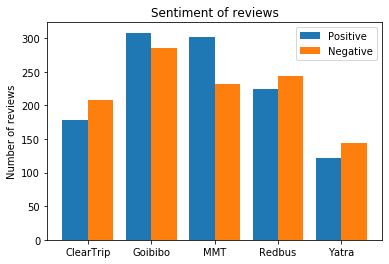

In [0]:
xpos = np.arange(len(OTA))
plt.bar(xpos-0.2,posi, width=0.4, label="Positive")
plt.bar(xpos+0.2,negi, width=0.4,label="Negative")

plt.xticks(xpos,OTA)
plt.ylabel("Number of reviews")
plt.title('Sentiment of reviews')
plt.legend()

['ClearTrip', 'Goibibo', 'MMT', 'Redbus', 'Yatra']


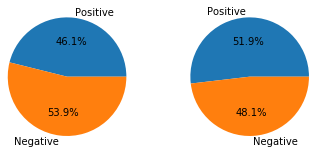

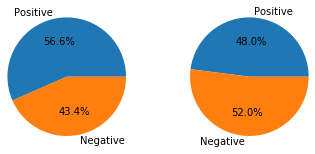

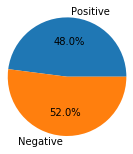

In [0]:
print(OTA)
'''
plt.axis("equal")
plt.pie(values,labels=sentiment, autopct='%1.1f%%',radius=1.5)
plt.show()
'''
plt.figure(1)
plt.subplot(221)
values = [posi[0] , negi[0]]
plt.pie(values,labels=sentiment, autopct='%1.1f%%',radius=1.5)

plt.subplot(222)
values = [posi[1] , negi[1]]
plt.pie(values,labels=sentiment, autopct='%1.1f%%',radius=1.5)

plt.figure(2)
plt.subplot(221)
values = [posi[2] , negi[2]]
plt.pie(values,labels=sentiment, autopct='%1.1f%%',radius=1.5)

plt.subplot(222)
values = [posi[3] , negi[3]]
plt.pie(values,labels=sentiment, autopct='%1.1f%%',radius=1.5)

plt.figure(3)
plt.subplot(221)
values = [posi[3] , negi[3]]
plt.pie(values,labels=sentiment, autopct='%1.1f%%',radius=1.5)



plt.show()
